# Simple Linear Elasticity FEnicsx tutorial

The following is a slightly modified version of the tutorial found at https://jsdokken.com/dolfinx-tutorial/chapter2/linearelasticity_code.html - please explore this site to view the original and for other in-depth tutorials.

In this tutorial, you will learn how to:

Use a vector function space

Create a constant boundary condition on a vector space

Visualize cell wise constant functions

Compute Von Mises stresses

### References
Hans Petter Langtangen and Anders Logg. Solving PDEs in Python: The FEniCS Tutorial I. Springer International Publishing, Cham, 2016. ISBN 978-3-319-52462-7. doi:10.1007/978-3-319-52462-7

## Test Problem

As a test example, we will model a clamped beam deformed under its own weigth in 3D. This can be modeled, by setting the right-hand side body force per unit volume to f = (0,0,-pg) with p the density of the beam and g the acceleration of gravity. The beam is box-shaped with length L and has a square cross section of width W. We set u = u_D = (0,0,0) at the clamped end, x=0. The rest of the boundary is traction free, that is, we set T = 0. We start by defining the physical variables used in the program.

In [34]:
# Scaled variable
import pyvista
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np
L = 5
W = 0.2
mu = 1
rho = 1
delta = W / L
gamma = 0.4 * delta**2
beta = 1.25
lambda_ = beta
g = gamma

We then create the mesh, which will consist of hexahedral elements, along with the function space. As we want a vector element with three components, we add (3, ) or (domain.geometry.dim, ) to the element tuple to make it a triplet However, we also could have used basix.ufls functionality, creating a vector element element = basix.ufl.element("Lagrange", domain.topology.cell_name(), 1, shape=(domain.geometry.dim,)), and initializing the function space as V = dolfinx.fem.functionspace(domain, element).

In [35]:
domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0, 0, 0]), np.array([L, W, W])],
                         [20, 6, 6], cell_type=mesh.CellType.hexahedron)
V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

## Boundary conditions
As we would like to clamp the boundary at x = 0, we do this by using a marker function, which locates the facets where x is close to zero by machine precision.

In [36]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)


fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

u_D = np.array([0, 0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

As we want the traction T over the remaining boundary to be 0, we create a dolfinx.Constant

In [37]:
T = fem.Constant(domain, default_scalar_type((0, 0, 0)))

We also want to specify the integration measure ds, which should be the integral over the boundary of our domain. We do this by using ufl, and its built in integration measures

In [38]:
ds = ufl.Measure("ds", domain=domain)

## Variational formulation
We are now ready to create our variational formulation in close to mathematical syntax.

In [39]:
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)


u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

## Solve the linear variational problem
We assemble the matrix and right hand side vector and use PETSc to solve our variational problem

In [40]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Visualization
We can visualize the results using Pyvista, adding vectors to the grid instead of scalar values.

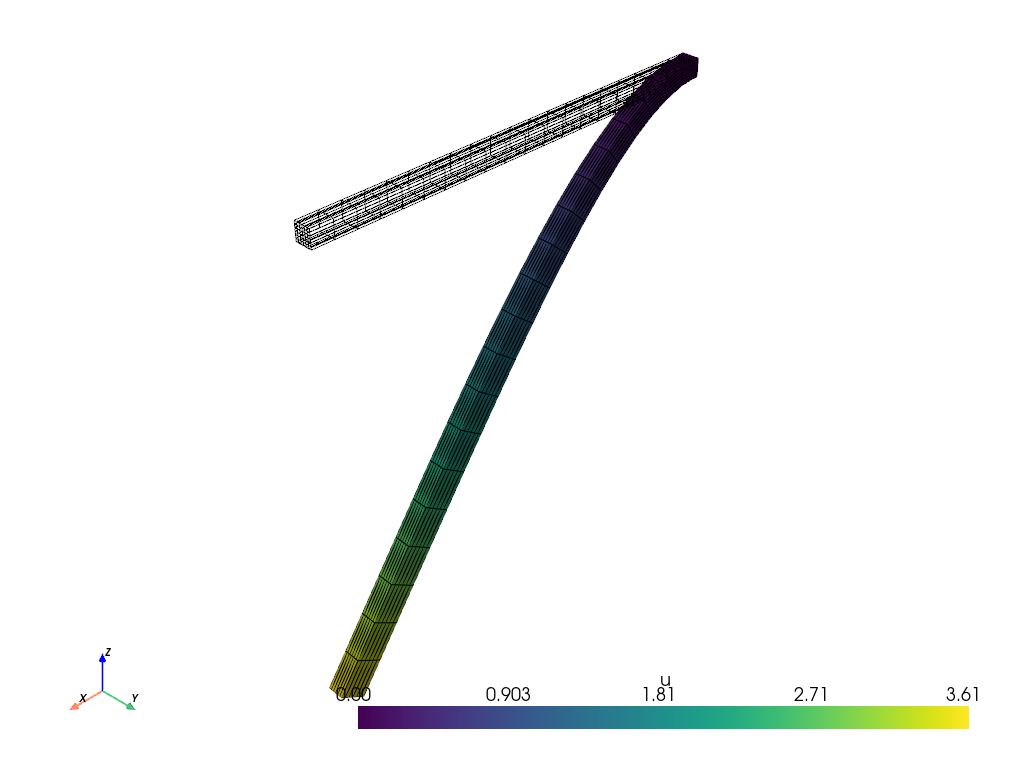

In [41]:
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

## Stress Computation

In [42]:
s = sigma(uh) - 1. / 3 * ufl.tr(sigma(uh)) * ufl.Identity(len(uh))
von_Mises = ufl.sqrt(3. / 2 * ufl.inner(s, s))

The von_Mises variable is now an expression that must be projected into an appropriate function space so that we can visualize it. As uh is a linear combination of first order piecewise continuous functions, the von Mises stresses will be a cell-wise constant function.

In [43]:
V_von_mises = fem.functionspace(domain, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_von_mises.element.interpolation_points())
stresses = fem.Function(V_von_mises)
stresses.interpolate(stress_expr)

In the previous sections, we have only visualized first order Lagrangian functions. However, the Von Mises stresses are piecewise constant on each cell. Therefore, we modify our plotting routine slightly. The first thing we notice is that we now set values for each cell, which has a one to one correspondence with the degrees of freedom in the function space.

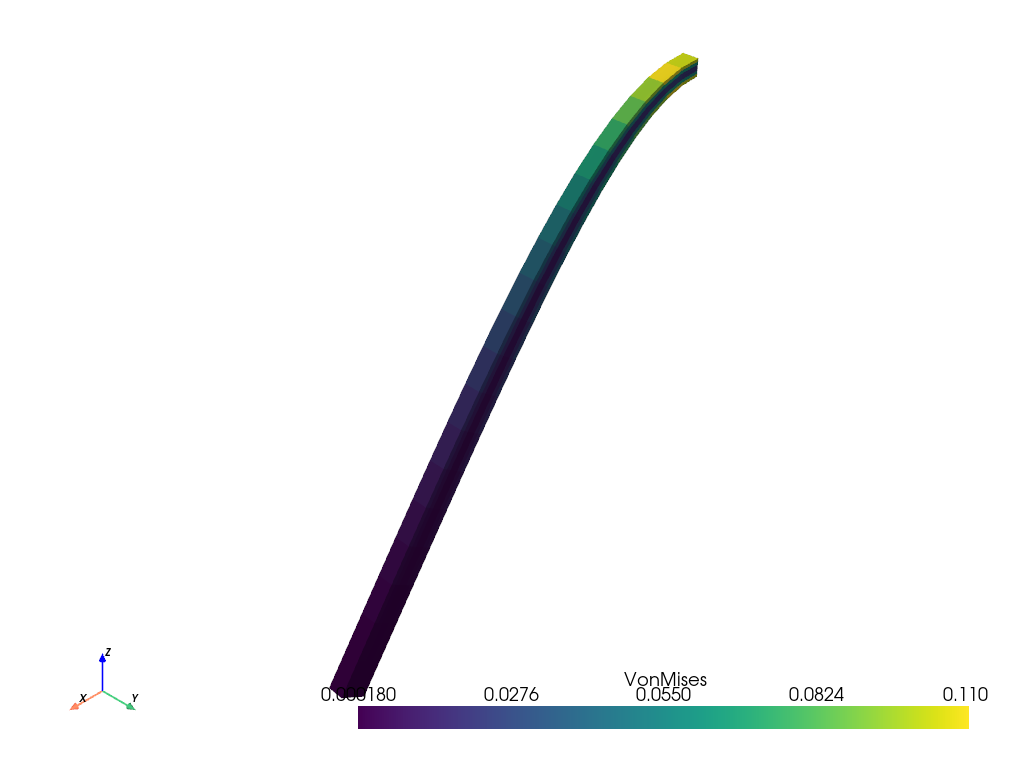

In [44]:
warped.cell_data["VonMises"] = stresses.x.petsc_vec.array
warped.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(warped)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    stress_figure = p.screenshot(f"stresses.png")